In [1]:
print('Hi')

Hi


In [2]:
import pink_utils as pu
import pandas as pd
import numpy as np
import time

In [3]:
hm = pu.heatmap('../Experiment/Experiment_F3W2_95_5/F3W2_95_5_Testing_Images_EDMatrix.bin')
images = pu.image_binary('../Experiment/Experiment_F3W2_95_5/F3W2_95_5_Testing_Images.bin')

In [4]:
df = pd.read_csv('../Experiment/Experiment_F3W2_95_5/Test_Images/RGZ_Test_Images_Dataframe.csv')

In [5]:
df.shape

(7464, 78)

In [6]:
images.file_head

(7464, 2, 167, 167)

In [7]:
hm.file_head

(7464, 15, 15, 1)

In [8]:
before = time.time()
print(f'Before time is {before}')
print('Loading the heatmaps')
maps = [hm.ed(index=i, prob=True) for i in range(hm.file_head[0])]

# print('Loading the FIRST pre-processed images')
# first = [images.get_image(index=i, channel=0) for i in range(hm.file_head[0])]

# print('Loading the WISE pre-processed images')
# wise = [images.get_image(index=i, channel=1) for i in range(hm.file_head[0])]

print('Loading the cube pre-processed images')
cubes = [np.concatenate([images.get_image(index=i, channel=0).flatten(), images.get_image(index=i, channel=1).flatten()]) for i in range(hm.file_head[0])]

after = time.time()
print(f'After time is {after}')
print(f'\tTime difference is {after-before}')


Before time is 1530423614.929948
Loading the heatmaps
Loading the cube pre-processed images
After time is 1530423687.7499645
	Time difference is 72.82001638412476


In [9]:
import matplotlib.pyplot as plt

In [10]:
from collections import defaultdict

In [11]:
book = defaultdict(list)

for c, row in df.iterrows():
    book[row['label']].append(maps[c])

In [12]:
som = pu.som('../Experiment/Experiment_F3W2_95_5/Results/F3W2_95_5/F3W2S_95_5_6_19.bin')

/mnt/software/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


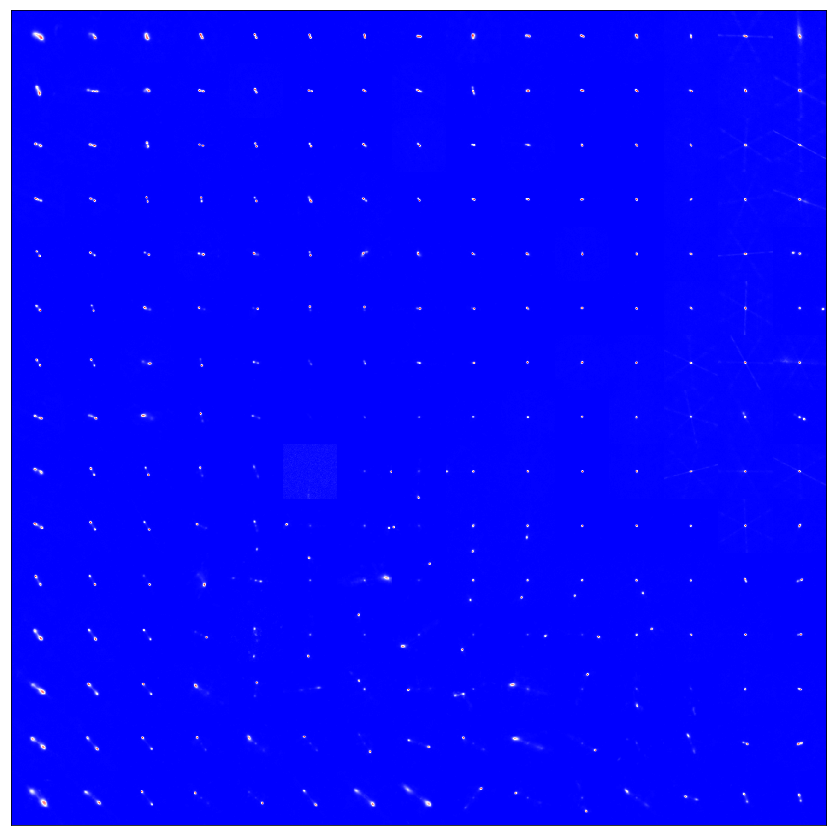

In [13]:
fig, ax  = plt.subplots(1,1, figsize=(15,15))

ax.imshow(som.get_som(channel=0), cmap='bwr')
pu.no_ticks(ax)

fig.show()

/mnt/software/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


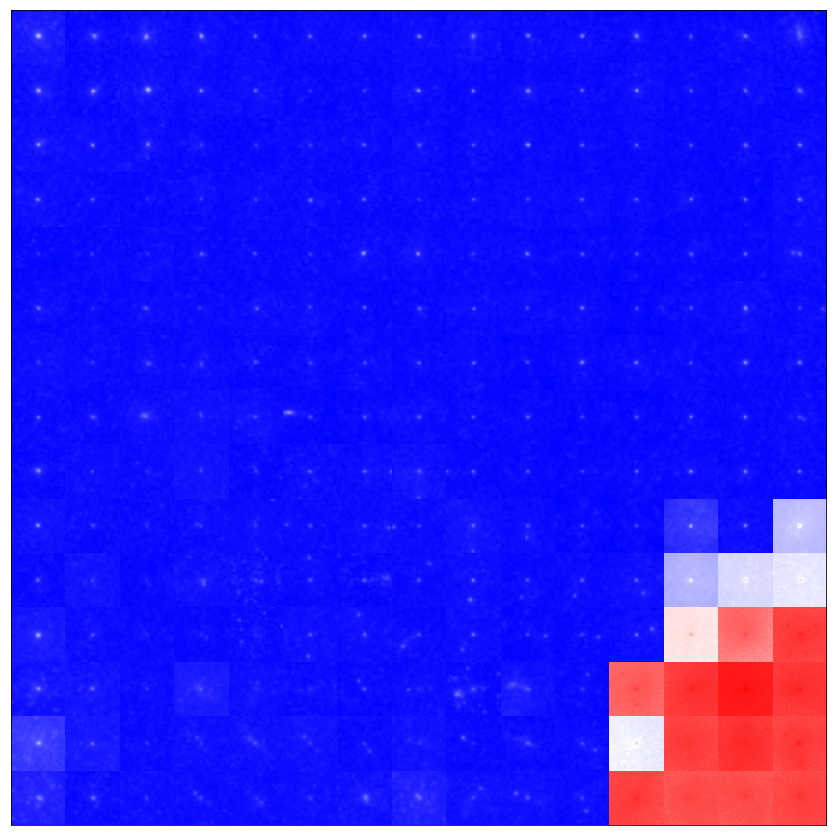

In [14]:
fig, ax  = plt.subplots(1,1, figsize=(15,15))

ax.imshow(som.get_som(channel=1), cmap='bwr')
pu.no_ticks(ax)

fig.show()

In [15]:
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn import cross_validation

/mnt/home/tim/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [16]:
np.array(cubes).shape

(7464, 55778)

In [17]:
np.random.seed(7464)
index = np.random.permutation(len(maps))

labels = df['label']
num_comp  = np.array([int(i.split('_')[0]) for i in labels])[index]
num_peaks = np.array([int(i.split('_')[1]) for i in labels])[index]

# Keep heat maps to ensure nothing else breaks
heatmaps  = np.array(cubes)[index]

total = heatmaps.shape[0]

suf_df = df.iloc[index]


In [18]:
before = time.time()
print(f'Before time is {before}')

n_estimators = 64 # how many trees, should be 256
cores = 4 # number of cpu cores to speed it up

peaks_rf = RandomForestRegressor(n_estimators=n_estimators, n_jobs=cores, bootstrap=True)
comp_rf  = RandomForestRegressor(n_estimators=n_estimators, n_jobs=cores, bootstrap=True)

print('Peaks training')
peaks_res = cross_validation.cross_val_predict(peaks_rf, heatmaps, num_peaks, 
                                               cv=5, n_jobs=-1, verbose=3)

print('Comp training')
comp_res = cross_validation.cross_val_predict(comp_rf, heatmaps, num_comp, 
                                              cv=5, n_jobs=-1, verbose=3)

after = time.time()
print(f'After time is {after}')
print(f'\tTime difference is {after-before}')


Before time is 1530423800.7676952
Peaks training


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 152.2min remaining: 228.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 158.6min finished


Comp training


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 218.5min remaining: 327.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 241.8min finished


After time is 1530447828.991211
	Time difference is 24028.223515748978


In [22]:
import pickle

pickle.dump(peaks_rf, open('random_forest_peaks.pkl','wb'))
pickle.dump(comp_rf, open('random_forest_comps.pkl','wb'))

(55778,)


/mnt/software/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


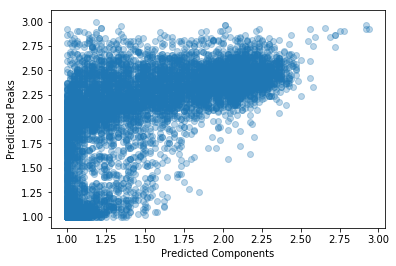

In [23]:
print(heatmaps[0].shape)

fig, ax = plt.subplots(1,1)

ax.scatter(comp_res, peaks_res, alpha=0.3)

ax.set(xlabel='Predicted Components',
       ylabel='Predicted Peaks')

fig.show()

/mnt/software/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


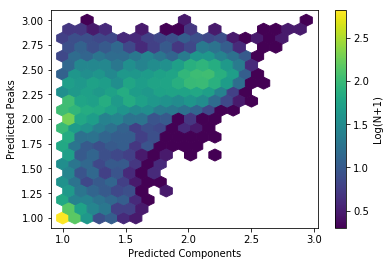

In [24]:
fig, ax = plt.subplots(1,1)

hb = ax.hexbin(comp_res, peaks_res, 
               bins='log', gridsize=20, mincnt=1)

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Log(N+1)')

ax.set(xlabel='Predicted Components',
       ylabel='Predicted Peaks')

fig.show()
# fig.savefig('Images/Predicted_Features_Heatmap.pdf')

/mnt/software/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


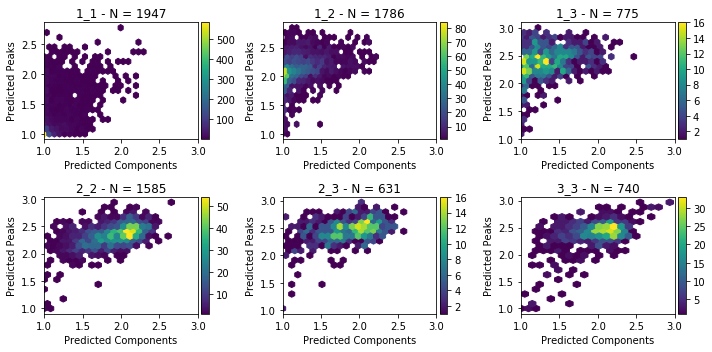

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def subplot_cbar(fig, ax, im):
        divider = make_axes_locatable(ax)
        cax0 = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax0)
    

fig, axes = plt.subplots(2,3, figsize=(10, 5))

for c, l in enumerate(np.sort(labels[index].unique())):
    mask = l == labels[index]
    
    ax = axes.flatten()[c]
    im = ax.hexbin(comp_res[mask], peaks_res[mask], gridsize=20, mincnt=1)
    ax.set(title=f'{l} - N = {np.sum(mask)}', xlim=[1,3],
          xlabel='Predicted Components',
          ylabel='Predicted Peaks')
    
    subplot_cbar(fig, ax, im)
    
fig.tight_layout()
fig.show()
fig.savefig('Images/Predicted_Features_Heatmap_Classes_Pink_Images.pdf')

/mnt/software/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


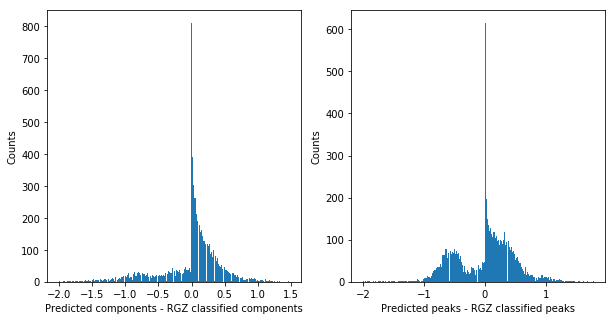

In [26]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.hist( comp_res - num_comp, bins=250 )
ax1.set(xlabel='Predicted components - RGZ classified components',
        ylabel='Counts')

ax2.hist( peaks_res - num_peaks, bins=250 )
ax2.set(xlabel='Predicted peaks - RGZ classified peaks',
        ylabel='Counts')


fig.show()
fig.savefig('Images/Predicted_Featurs_Histogram_Pink_Images.pdf')

/mnt/software/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


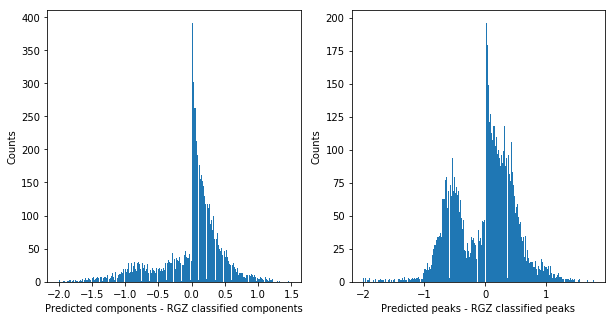

In [27]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

val = comp_res - num_comp
ax1.hist( val[val!=0], bins=250 )
ax1.set(xlabel='Predicted components - RGZ classified components',
        ylabel='Counts')

val = peaks_res - num_peaks
ax2.hist(val[val != 0], bins=250 )
ax2.set(xlabel='Predicted peaks - RGZ classified peaks',
        ylabel='Counts')


fig.show()
fig.savefig('Images/Predicted_Featurs_Histogram_No_Zero_Pink_Images.pdf')

0.6-0.7
0.7-0.8
0.8-0.9
0.9-1.0


/mnt/software/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


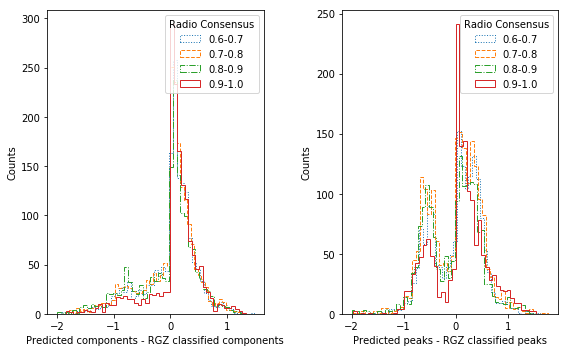

In [28]:
bin_df = pd.cut(suf_df['consensus.ir_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,5))
linestyles = [':','--','-.','-']

for c, b in enumerate(np.sort(bin_df.unique())):
    print(b)
    mask = b == bin_df
    
    val = comp_res - num_comp
    ax1.hist( val[(mask)&(val!=0)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
    
    val = peaks_res - num_peaks
    ax2.hist(val[(mask)&(val!=0)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])

ax1.set(xlabel='Predicted components - RGZ classified components',
            ylabel='Counts')
ax2.set(xlabel='Predicted peaks - RGZ classified peaks',
        ylabel='Counts')

ax1.legend(title='Radio Consensus')
ax2.legend(title='Radio Consensus')
fig.tight_layout()
fig.show()



0.9-1.0
0.8-0.9
0.7-0.8
0.6-0.7


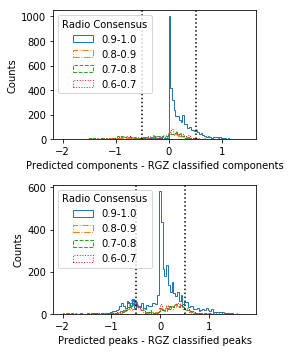

In [29]:
bin_df = pd.cut(suf_df['consensus.radio_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(4,5))
linestyles = [':','--','-.','-'][::-1]

for c, b in enumerate(np.sort(bin_df.unique())[::-1]):
    print(b)
    mask = b == bin_df
    
    val = comp_res - num_comp
    ax1.hist( val[mask], bins=100, label=f'{b}', histtype='step', linestyle=linestyles[c])
    
    val = peaks_res - num_peaks
    ax2.hist(val[mask], bins=100, label=f'{b}', histtype='step', linestyle=linestyles[c])

ax1.set(xlabel='Predicted components - RGZ classified components',
            ylabel='Counts')
ax2.set(xlabel='Predicted peaks - RGZ classified peaks',
        ylabel='Counts')

ax1.axvline(-0.5, linestyle=':', color='black')
ax1.axvline(0.5, linestyle=':', color='black')

ax2.axvline(-0.5, linestyle=':', color='black')
ax2.axvline(0.5, linestyle=':', color='black')


ax1.legend(title='Radio Consensus', loc='upper left')
ax2.legend(title='Radio Consensus', loc='upper left')
fig.tight_layout()
# fig.show()
fig.savefig('Images/Figure_MSE_Histogram_CL_Pink_Images.pdf')

In [30]:
val_comp = comp_res - num_comp
val_peaks = peaks_res - num_peaks

mask_comp = (val_comp >= -0.5) & (val_comp < 0.5)
mask_peaks = (val_peaks > -0.5) & (val_peaks < 0.5)

print(np.sum(mask_comp)/len(val_comp))
print(np.sum(np.abs(val_comp[mask_comp])))
print(np.sum(mask_peaks)/len(val_comp))
print(np.sum(np.abs(val_peaks[mask_peaks])))

0.7829581993569131
915.7092075892857
0.6840836012861736
1059.0572916666665


In [31]:
val_comp = comp_res - num_comp
val_peaks = peaks_res - num_peaks

mask_comp = ~((val_comp >= -0.5) & (val_comp < 0.5))
mask_peaks = ~((val_peaks > -0.5) & (val_peaks < 0.5))

print(np.sum(mask_comp)/len(val_comp))
print(np.sum(np.abs(val_comp[mask_comp])))
print(np.sum(mask_peaks)/len(val_comp))
print(np.sum(np.abs(val_peaks[mask_peaks])))

0.2170418006430868
1372.4497767857142
0.3159163987138264
1702.65


0.6-0.7
0.7-0.8
0.8-0.9
0.9-1.0


/mnt/software/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


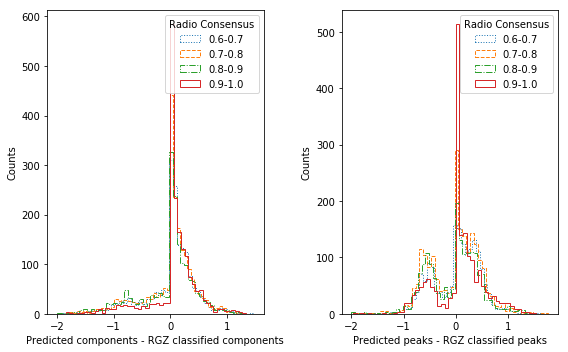

In [32]:
bin_df = pd.cut(suf_df['consensus.ir_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,5))
linestyles = [':','--','-.','-']

for c, b in enumerate(np.sort(bin_df.unique())):
    print(b)
    mask = b == bin_df
    
    val = comp_res - num_comp
    ax1.hist( val[mask], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
    
    val = peaks_res - num_peaks
    ax2.hist(val[mask], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])

ax1.set(xlabel='Predicted components - RGZ classified components',
            ylabel='Counts')
ax2.set(xlabel='Predicted peaks - RGZ classified peaks',
        ylabel='Counts')

ax1.legend(title='Radio Consensus')
ax2.legend(title='Radio Consensus')
fig.tight_layout()
fig.show()


/mnt/software/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


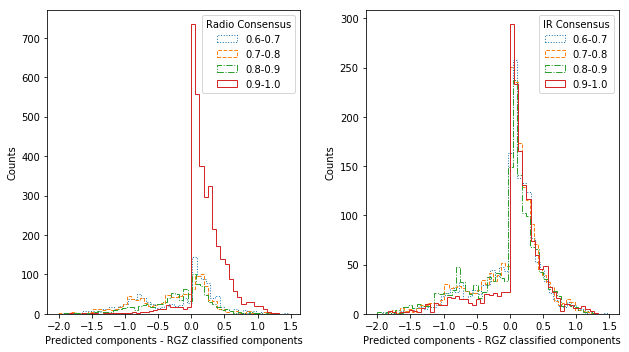

In [33]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(9,5))
linestyles = [':','--','-.','-']

val = comp_res - num_comp

bin_df = pd.cut(suf_df['consensus.radio_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])
for c, b in enumerate(np.sort(bin_df.unique())):
    mask = b == bin_df    
    ax1.hist( val[(mask)&(val!=0)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])

    
bin_df = pd.cut(suf_df['consensus.ir_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])
for c, b in enumerate(np.sort(bin_df.unique())):
    mask = b == bin_df    
    ax2.hist( val[(mask)&(val!=0)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])

ax1.set(xlabel='Predicted components - RGZ classified components',
            ylabel='Counts')
ax2.set(xlabel='Predicted components - RGZ classified components',
        ylabel='Counts')

ax1.legend(title='Radio Consensus')
ax2.legend(title='IR Consensus')
fig.tight_layout()
fig.show()
# fig.savefig('Images/Components_Histogram_Consensus.pdf')


/mnt/software/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


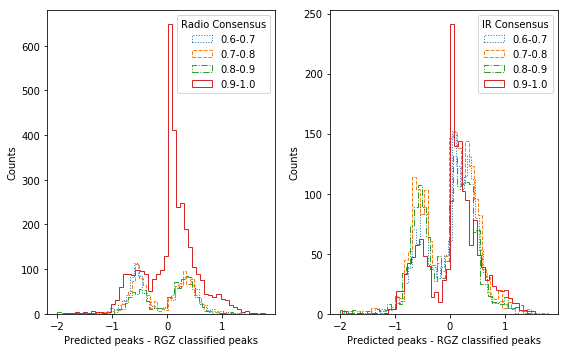

In [35]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,5))
linestyles = [':','--','-.','-']

val = peaks_res - num_peaks

bin_df = pd.cut(suf_df['consensus.radio_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])
for c, b in enumerate(np.sort(bin_df.unique())):
    mask = b == bin_df    
    ax1.hist( val[(mask)&(val!=0)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])

    
bin_df = pd.cut(suf_df['consensus.ir_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])
for c, b in enumerate(np.sort(bin_df.unique())):
    mask = b == bin_df    
    ax2.hist( val[(mask)&(val!=0)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])

ax1.set(xlabel='Predicted peaks - RGZ classified peaks',
            ylabel='Counts')
ax2.set(xlabel='Predicted peaks - RGZ classified peaks',
        ylabel='Counts')

ax1.legend(title='Radio Consensus')
ax2.legend(title='IR Consensus')
fig.tight_layout()
fig.show()
fig.savefig('Images/Peaks_Histogram_Consensus_Pink_Images.pdf')

/mnt/software/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


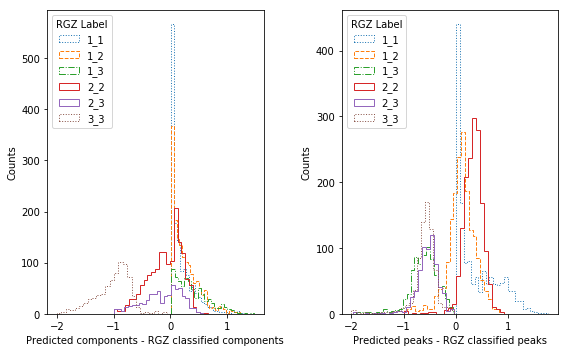

In [36]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,5))
linestyles = [':','--','-.','-', '-',':']

val = comp_res - num_comp

bin_df = np.unique(suf_df['label'])
for c, b in enumerate(np.sort(bin_df)):
    mask = b ==  suf_df['label']   
    ax1.hist( val[(mask)&(val!=0)], bins=25, label=f'{b}', histtype='step', linestyle=linestyles[c])


val = peaks_res - num_peaks


bin_df = np.unique(suf_df['label'])
for c, b in enumerate(np.sort(bin_df)):
    mask = b == suf_df['label']    
    ax2.hist( val[(mask)&(val!=0)], bins=25, label=f'{b}', histtype='step', linestyle=linestyles[c])

ax1.set(xlabel='Predicted components - RGZ classified components',
            ylabel='Counts')
ax2.set(xlabel='Predicted peaks - RGZ classified peaks',
        ylabel='Counts')

ax1.legend(title='RGZ Label')
ax2.legend(title='RGZ Label')
fig.tight_layout()
fig.show()
fig.savefig('Images/RGZ_Label_Predicted_Features_Pink_Images.pdf')

/mnt/software/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


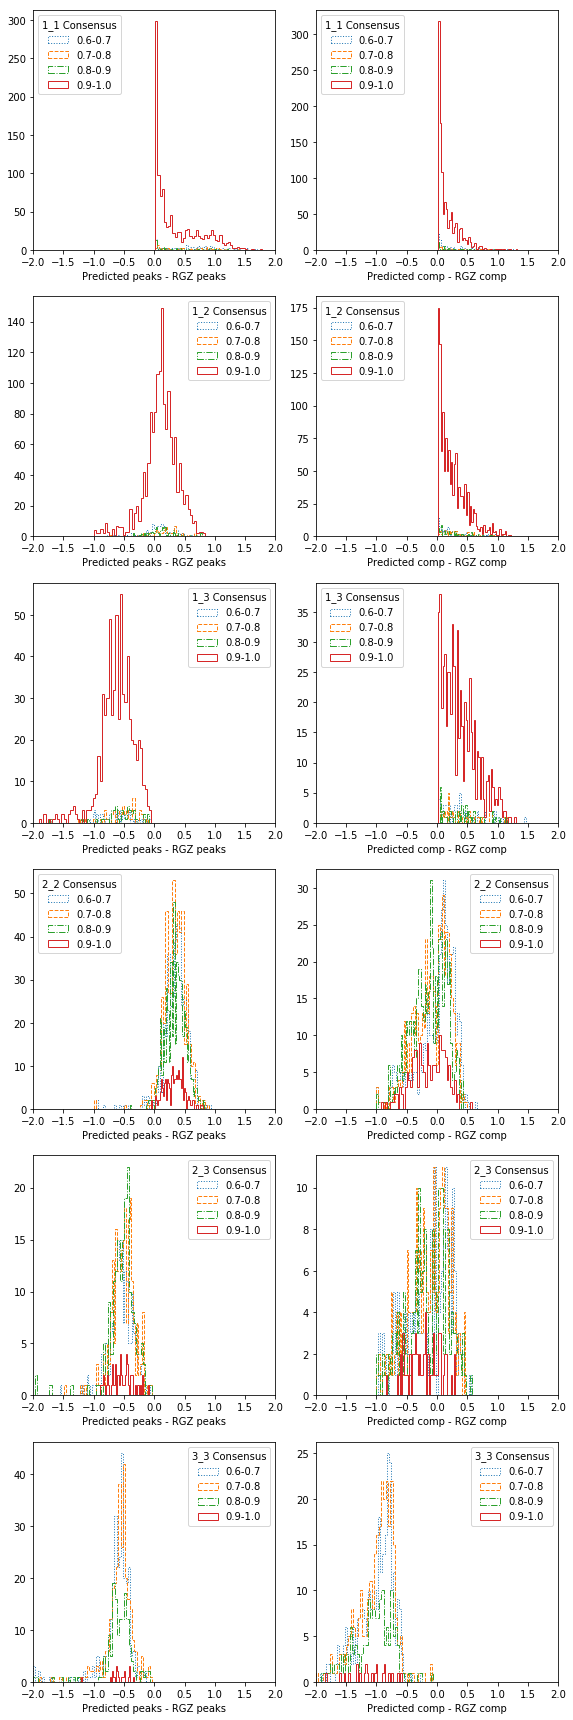

In [37]:
bin_df = np.unique(suf_df['label'])
linestyles = [':','--','-.','-', '-',':']

fig, axes = plt.subplots(len(bin_df), 2, figsize=(8, len(bin_df)*4))

for count, l in enumerate(np.sort(bin_df)):
    ax1, ax2 = axes[count]
    
    l_mask = l == suf_df['label']
    val_peak = peaks_res - num_peaks
    val_comp = comp_res - num_comp 
    
    cen_df = pd.cut(suf_df['consensus.radio_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])
    for c, b in enumerate(np.sort(cen_df.unique())):
        mask = b == cen_df    
        ax1.hist( val_peak[(mask)&(val_peak!=0)&(l_mask)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
        ax1.legend(title=f'{l} Consensus')
        ax1.set(xlim=[-2,2], xlabel='Predicted peaks - RGZ peaks')
        
        ax2.hist( val_comp[(mask)&(val_comp!=0)&(l_mask)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
        ax2.legend(title=f'{l} Consensus')
        ax2.set(xlim=[-2,2], xlabel='Predicted comp - RGZ comp')

fig.tight_layout()
fig.show()
fig.savefig('Images/Figure_Label_Consensus_Histogram_Pink_Images.pdf')

In [38]:
bin_df

array(['1_1', '1_2', '1_3', '2_2', '2_3', '3_3'], dtype=object)

/mnt/software/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


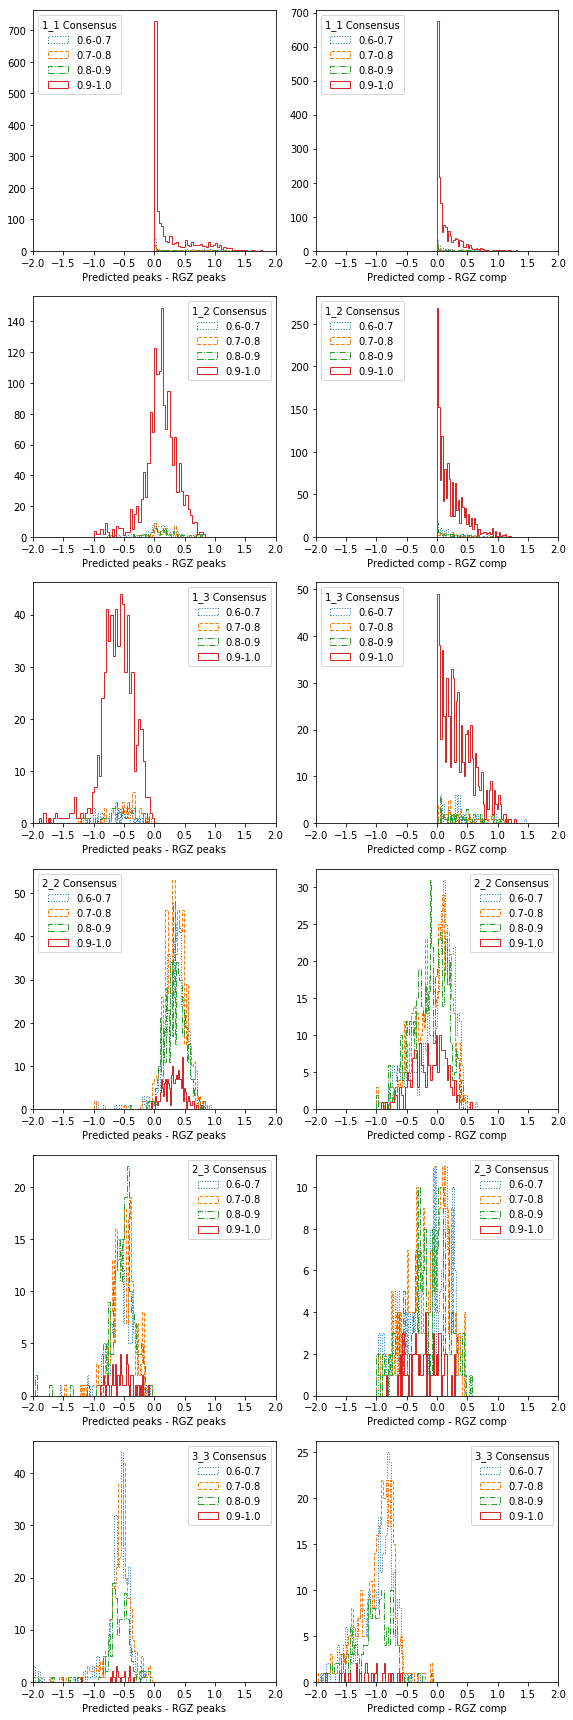

In [39]:
bin_df = np.unique(suf_df['label'])
linestyles = [':','--','-.','-', '-',':']

fig, axes = plt.subplots(len(bin_df), 2, figsize=(8, len(bin_df)*4))

for count, l in enumerate(np.sort(bin_df)):
    ax1, ax2 = axes[count]
    
    l_mask = l == suf_df['label']
    val_peak = peaks_res - num_peaks
    val_comp = comp_res - num_comp 
    
    cen_df = pd.cut(suf_df['consensus.radio_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])
    for c, b in enumerate(np.sort(cen_df.unique())):
        mask = b == cen_df    
        ax1.hist( val_peak[(mask)&(l_mask)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
        ax1.legend(title=f'{l} Consensus')
        ax1.set(xlim=[-2,2], xlabel='Predicted peaks - RGZ peaks')
        
        ax2.hist( val_comp[(mask)&(l_mask)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
        ax2.legend(title=f'{l} Consensus')
        ax2.set(xlim=[-2,2], xlabel='Predicted comp - RGZ comp')

fig.tight_layout()
fig.show()
fig.savefig('Images/Figure_Label_Consensus_Histogram_With_Zero_Pink_Images.pdf')

/mnt/software/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


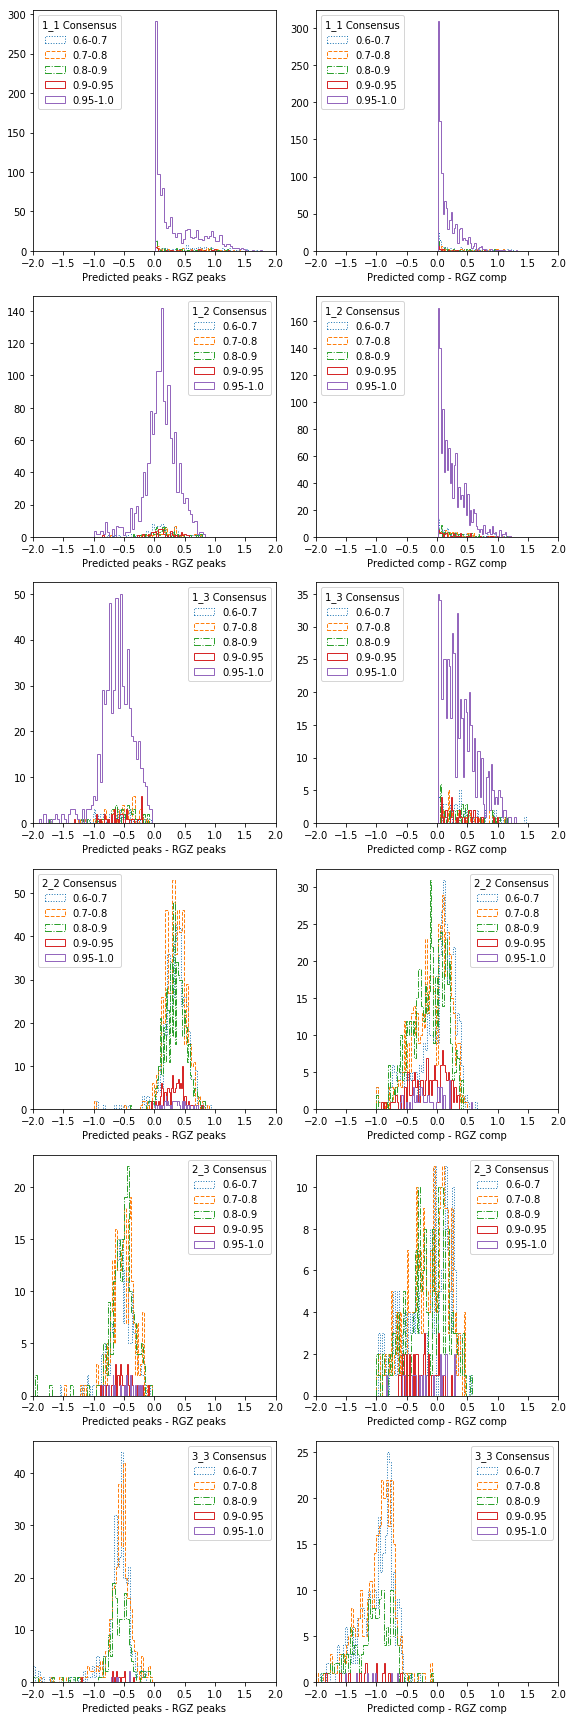

In [48]:
bin_df = np.unique(suf_df['label'])
linestyles = [':','--','-.','-', '-',':', '--']

fig, axes = plt.subplots(len(bin_df), 2, figsize=(8, len(bin_df)*4))

for count, l in enumerate(np.sort(bin_df)):
    ax1, ax2 = axes[count]
    
    l_mask = l == suf_df['label']
    val_peak = peaks_res - num_peaks
    val_comp = comp_res - num_comp 
    
    cen_df = pd.cut(suf_df['consensus.radio_level'] , [0.6, 0.7, 0.8, 0.9, 0.95, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-0.95', '0.95-1.0',])
    for c, b in enumerate(np.sort(cen_df.unique())):
        mask = b == cen_df    
        ax1.hist( val_peak[(mask)&(val_peak!=0)&(l_mask)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
        ax1.legend(title=f'{l} Consensus')
        ax1.set(xlim=[-2,2], xlabel='Predicted peaks - RGZ peaks')
        
        ax2.hist( val_comp[(mask)&(val_comp!=0)&(l_mask)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
        ax2.legend(title=f'{l} Consensus')
        ax2.set(xlim=[-2,2], xlabel='Predicted comp - RGZ comp')

fig.tight_layout()
fig.show()